**Warning**: Execution time of this notebook is long due to the large data size being processed (>100GB). The data can be downloaded from https://www.kaggle.com/c/siim-isic-melanoma-classification/data

Paths need to be adapted.

In [1]:
!pip install --upgrade fsspec

     |████████████████████████████████| 85 kB 529 kB/s 
  Attempting uninstall: fsspec
    Found existing installation: fsspec 0.7.2
    Uninstalling fsspec-0.7.2:
      Successfully uninstalled fsspec-0.7.2
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import re
import sys

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

import tensorflow as tf

     image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  
3   unknown           benign       0  
4   unknown           benign       0  


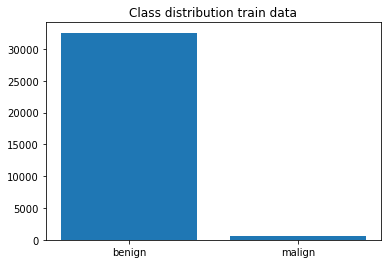

There is a total of 33126 images in the training data coming from 2056 patients.


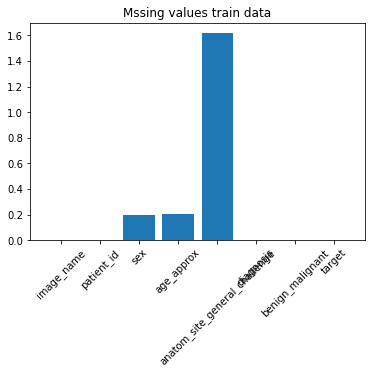

In [3]:
# load in metadata and inspect
path_train = KaggleDatasets().get_gcs_path('siim-isic-melanoma-classification') + '/train.csv'
path_test = KaggleDatasets().get_gcs_path('siim-isic-melanoma-classification') + '/test.csv'

metadata_train = pd.read_csv(path_train, header=0)
metadata_test = pd.read_csv(path_test, header=0)
print(metadata_train.head())

# check class distribution
target_dist_train = metadata_train['target'].value_counts()
plt.bar(['benign','malign'], target_dist_train)
plt.title('Class distribution train data')
plt.show()

n_patients = len(metadata_train['patient_id'].unique())
n_images = len(metadata_train['image_name'].unique())
print('There is a total of {} images in the training data coming from {} patients.'.format(n_images, n_patients))

# check missing values
n_train = metadata_train.count()
missings = metadata_train.isnull().sum() / n_train * 100
plt.bar(metadata_train.columns, missings)
plt.xticks(rotation=45)
plt.title('Mssing values train data')
plt.show()

In [4]:
# impute mssing values in train and test data
metadata_train['anatom_site_general_challenge'].fillna('missing', inplace=True)
metadata_test['anatom_site_general_challenge'].fillna('missing', inplace=True)
mode_sex = metadata_train['sex'].mode()
metadata_train['sex'].fillna(mode_sex[0], inplace=True)
metadata_test['sex'].fillna(mode_sex[0], inplace=True)
mean_age = metadata_train['age_approx'].mean()
metadata_train['age_approx'].fillna(mean_age, inplace=True)
metadata_test['age_approx'].fillna(mean_age, inplace=True)

In [5]:
# standardize and one-hot encode to get data ready for ML algorithm
sex_dummies_train = pd.get_dummies(metadata_train['sex'])
sex_dummies_test = pd.get_dummies(metadata_test['sex'])
location_dummies_train = pd.get_dummies(metadata_train['anatom_site_general_challenge'])
location_dummies_test = pd.get_dummies(metadata_test['anatom_site_general_challenge'])
metadata_train = pd.concat([metadata_train, sex_dummies_train, location_dummies_train], axis=1)
metadata_test = pd.concat([metadata_test, sex_dummies_test, location_dummies_test], axis=1)

metadata_train.drop(['patient_id', 'benign_malignant', 'diagnosis', 'sex', 
                     'anatom_site_general_challenge'], axis = 1, inplace=True)
metadata_test.drop(['patient_id', 'sex', 
                     'anatom_site_general_challenge'], axis = 1, inplace=True)

mean_age = metadata_train['age_approx'].mean()
std_age = metadata_train['age_approx'].std()
metadata_train['age_approx'] = (metadata_train['age_approx'] - mean_age) / std_age
metadata_test['age_approx'] = (metadata_test['age_approx'] - mean_age) / std_age


# rename some columns for better handling
metadata_train.rename(columns = {'head/neck': 'head_neck',
                      'lower extremity': 'lower_extremity',
                      'oral/genital': 'oral_genital',
                      'palms/soles': 'palms_soles',
                      'upper extremity': 'upper_extremity'}, inplace=True)
metadata_test.rename(columns = {'head/neck': 'head_neck',
                      'lower extremity': 'lower_extremity',
                      'oral/genital': 'oral_genital',
                      'palms/soles': 'palms_soles',
                      'upper extremity': 'upper_extremity'}, inplace=True)

Lets now merge metadata with image data by writing to tfrecords

In [6]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def serialize_example(is_train, *agrs):
    # we need to hand code all features
    if is_train:
        feature = {
            'image': _bytes_feature(agrs[0]),
            'image_name': _bytes_feature(agrs[1]),
            'age_approx': _float_feature(agrs[2]),
            'female': _int64_feature(agrs[3]),
            'male': _int64_feature(agrs[4]),
            'head_neck': _int64_feature(agrs[5]),
            'lower_extremity': _int64_feature(agrs[6]),
            'missing': _int64_feature(agrs[7]),
            'oral_genital': _int64_feature(agrs[8]),
            'palms_soles': _int64_feature(agrs[9]),
            'torso': _int64_feature(agrs[10]),
            'upper_extremity': _int64_feature(agrs[11]),
            'target': _int64_feature(agrs[12])
      }
    else:
        feature = {
            'image': _bytes_feature(agrs[0]),
            'image_name': _bytes_feature(agrs[1]),
            'age_approx': _float_feature(agrs[2]),
            'female': _int64_feature(agrs[3]),
            'male': _int64_feature(agrs[4]),
            'head_neck': _int64_feature(agrs[5]),
            'lower_extremity': _int64_feature(agrs[6]),
            'missing': _int64_feature(agrs[7]),
            'oral_genital': _int64_feature(agrs[8]),
            'palms_soles': _int64_feature(agrs[9]),
            'torso': _int64_feature(agrs[10]),
            'upper_extremity': _int64_feature(agrs[11])
      }
    protobuf = tf.train.Example(features=tf.train.Features(feature=feature))
    return protobuf.SerializeToString()

In [7]:
# load in images
path_train_img = '../input/siim-isic-melanoma-classification/jpeg/train'
path_test_img = '../input/siim-isic-melanoma-classification/jpeg/test'
file_size_train = 2071
file_size_test = 687

Writing TFrecord 0 of 16
0  
100  
200  
300  
400  
500  
600  
700  
800  
900  
1000  
1100  
1200  
1300  
1400  
1500  
1600  
1700  
1800  
1900  
2000  
Writing TFrecord 1 of 16
0  
100  
200  
300  
400  
500  
600  
700  
800  
900  
1000  
1100  
1200  
1300  
1400  
1500  
1600  
1700  
1800  
1900  
2000  
Writing TFrecord 2 of 16
0  
100  
200  
300  
400  
500  
600  
700  
800  
900  
1000  
1100  
1200  
1300  
1400  
1500  
1600  
1700  
1800  
1900  
2000  
Writing TFrecord 3 of 16
0  
100  
200  
300  
400  
500  
600  
700  
800  
900  
1000  
1100  
1200  
1300  
1400  
1500  
1600  
1700  
1800  
1900  
2000  
Writing TFrecord 4 of 16
0  
100  
200  
300  
400  
500  
600  
700  
800  
900  
1000  
1100  
1200  
1300  
1400  
1500  
1600  
1700  
1800  
1900  
2000  
Writing TFrecord 5 of 16
0  
100  
200  
300  
400  
500  
600  
700  
800  
900  
1000  
1100  
1200  
1300  
1400  
1500  
1600  
1700  
1800  
1900  
2000  
Writing TFrecord 6 of 16
0  
100  
200  

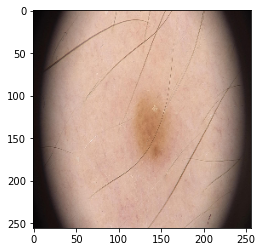

In [8]:
# write TFRecords
def tfrecord(path, file_size, metadata):
    """store it in a set of files (100-200MB each) that can each be read linearly"""
    imgs = os.listdir(path)
    n_imgs = len(imgs)
    
    n_files = n_imgs//file_size + int(n_imgs%file_size!=0)
    # iterate over number of TFrecords that will be written
    for i in range(n_files):
        print('Writing TFrecord {} of {}'.format(i, n_files))
        # in case images cannot be distributed evenly accross all files
        this_file_size = min(file_size, n_imgs-i*file_size)
        if 'train' in path:
            record_path = 'train{}-{}.tfrec'.format(i, this_file_size)
        else:
            record_path = 'test{}-{}.tfrec'.format(i, this_file_size)
        with tf.io.TFRecordWriter(record_path) as writer:
            # iterate over images in the range of file_size
            for j in range(this_file_size):
                img = cv2.imread(path+'/'+imgs[file_size*i+j])
                img = cv2.resize(img, (256, 256))
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                plt.imshow(img)
                img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 94))[1].tostring()
                
                #break
                name = imgs[file_size*i+j][:-4] # get rid of .jpg extension
                sample = metadata.loc[metadata.image_name==name]
                if 'train' in path:
                    protocol = serialize_example(True,
                                              img,
                                              str.encode(name),
                                              sample.age_approx.values[0],
                                               sample.female.values[0],
                                               sample.male.values[0],
                                               sample.head_neck.values[0],
                                               sample.lower_extremity.values[0],
                                               sample.missing.values[0],
                                               sample.oral_genital.values[0],
                                               sample.palms_soles.values[0],
                                               sample.torso.values[0],
                                               sample.upper_extremity.values[0],
                                               sample.target.values[0]
                                              )
                else:
                    protocol = serialize_example(False,
                                              img,
                                              str.encode(name),
                                              sample.age_approx.values[0],
                                               sample.female.values[0],
                                               sample.male.values[0],
                                               sample.head_neck.values[0],
                                               sample.lower_extremity.values[0],
                                               sample.missing.values[0],
                                               sample.oral_genital.values[0],
                                               sample.palms_soles.values[0],
                                               sample.torso.values[0],
                                               sample.upper_extremity.values[0]
                                              )
                writer.write(protocol)
                # progress bar
                if j%100==0:
                    print(j,' ')
        #break
        
        
tfrecord(path_train_img, file_size_train, metadata_train)
tfrecord(path_test_img, file_size_test, metadata_test)

In [9]:
!ls -l

total 951424
---------- 1 root root   201857 Aug 23 14:35 __notebook__.ipynb
-rw-r--r-- 1 root root 15567628 Aug 23 13:51 test0-687.tfrec
-rw-r--r-- 1 root root 15221360 Aug 23 13:53 test1-687.tfrec
-rw-r--r-- 1 root root 15623747 Aug 23 14:13 test10-687.tfrec
-rw-r--r-- 1 root root 15452616 Aug 23 14:16 test11-687.tfrec
-rw-r--r-- 1 root root 15532221 Aug 23 14:18 test12-687.tfrec
-rw-r--r-- 1 root root 15317924 Aug 23 14:20 test13-687.tfrec
-rw-r--r-- 1 root root 15602446 Aug 23 14:23 test14-687.tfrec
-rw-r--r-- 1 root root 15399742 Aug 23 14:25 test15-677.tfrec
-rw-r--r-- 1 root root 15488214 Aug 23 13:55 test2-687.tfrec
-rw-r--r-- 1 root root 15672274 Aug 23 13:57 test3-687.tfrec
-rw-r--r-- 1 root root 15576143 Aug 23 14:00 test4-687.tfrec
-rw-r--r-- 1 root root 15604775 Aug 23 14:02 test5-687.tfrec
-rw-r--r-- 1 root root 15464418 Aug 23 14:04 test6-687.tfrec
-rw-r--r-- 1 root root 15508255 Aug 23 14:06 test7-687.tfrec
-rw-r--r-- 1 root root 15577109 Aug 23 14:09 test8-687.tfrec
-r